# Michele Banfi 869294

In this exercise we needed to implement the grover algorithm in a non-trivial way to solve the boolean SAT problem.

In [1]:
# import libraries
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
import numpy as np
from colorsys import hls_to_rgb

In [3]:
# function to plot phases of the states
def plot_statevector_circles(statevector, figsize=(8, 8)):
    num_qubits = int(np.log2(len(statevector)))
    num_states = len(statevector)
    
    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_states)))  
 
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
 
    # Calculate radius for circles (adjust based on grid size)
    radius = 0.4 / grid_size 
 
    # Iterate through basis states and position circles on the grid
    for i, amp in enumerate(statevector):
        row = grid_size - (i // grid_size) - 1
        col = i % grid_size
 
        x = col * 2 * radius + radius  # Center x-coordinate of the circle
        y = row * 2 * radius + radius  # Center y-coordinate of the circle
 
        phase = np.angle(amp)
        hue = (phase + np.pi) / (2 * np.pi)  # Map phase to hue (0 to 1)
        color = hls_to_rgb(hue, 0.5, 1)
 
        circle = plt.Circle((x, y), np.abs(amp)*radius, color=color, alpha=0.5)  
        ax.add_artist(circle)
 
        ax.text(x, y, f"{bin(i)[2:].zfill(num_qubits)}", ha='center', va='center', fontsize=6)  
 
    # Set plot limits (adjust as needed)
    ax.set_xlim([0, grid_size * 2 * radius])
    ax.set_ylim([0, grid_size * 2 * radius])
    ax.set_title("Statevector Circle Notation")
    ax.set_xticks([]) # Remove x-axis ticks
    ax.set_yticks([]) # Remove y-axis ticks    
    plt.show()

As first attempt we want to implement this boolean expression in a circuit. Boolean expression: $(A \lor  (\neg B)) \land (B \lor (\neg A))$

In [9]:
# initialize the circuit
qc = QuantumCircuit(4)

# the qubits representing A and B are putted in superposition
qc.h([0, 1])
qc.barrier()

# then the first part of the expression is translated A AND (NOT B)
qc.x(1)
qc.x([0, 1]) # a second X is putted to the qubit in position 1 because in the formula we have NOT B
qc.mcx([0, 1], 2)
qc.x([0, 1])
qc.x(2)
qc.barrier()

# second part is implemented, B AND (NOT A)
qc.x(1)
qc.x(0)
qc.x([0, 1])
qc.mcx([0, 1], 3)
qc.x([0, 1])
qc.x(3)

# this brief section is for the central AND of the formula. The previous 2 blocks needs to be in AND together
qc.barrier()
qc.cz(2, 3)
qc.barrier()

# not we just to rewrite the previous part in reverse
qc.x(3)
qc.x([0, 1])
qc.mcx([0, 1], 3)
qc.x([0, 1])
qc.x(0)
qc.x(1)
qc.barrier()

qc.x(2)
qc.x([0, 1])
qc.mcx([0, 1], 2)
qc.x([0, 1])
qc.x(1)

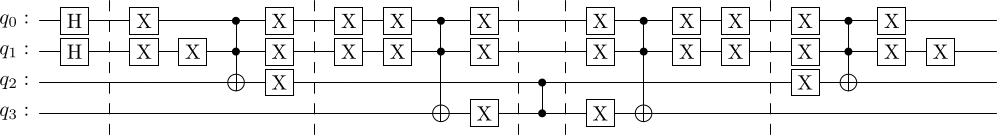

In [10]:
circuit_drawer(qc, output="latex")

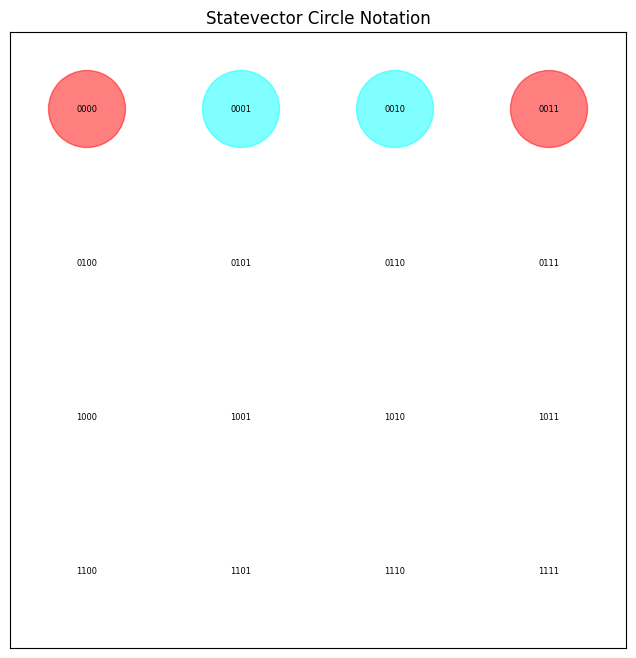

In [11]:
# Now we can plot the phase of the solution with the function written above

# create statevector
statevector = Statevector(qc)
# plot statevector
plot_statevector_circles(statevector)

Now we can implement a more difficult expression like the following, boolean expression: $(A \lor B) \land (\neg A \lor C) \land (\neg B \lor \neg C) \land (A \lor C) $

In [71]:
qc =  QuantumCircuit(7)
qc.h([0, 1, 2])
qc.x([0, 1])
qc.mcx([0, 1], 3)
qc.x([0, 1, 3])
qc.barrier()
qc.x([0])
qc.x([0, 2])
qc.mcx([0, 2], 4)
qc.x([0, 2, 4])
qc.x([0])
qc.barrier()
qc.x([1, 2])
qc.x([1, 2])
qc.mcx([1, 2], 5)
qc.x([1, 2, 5])
qc.x([1, 2])
qc.barrier()
qc.x([0, 2])
qc.mcx([0, 2], 6)
qc.x([0, 2, 6])

qc.barrier()
qc.mcp(np.pi, [3, 4, 5], 6)
qc.barrier()

qc.x([0, 2, 6])
qc.mcx([0, 2], 6)
qc.x([0, 2])
qc.barrier()
qc.x([1, 2])
qc.x([1, 2, 5])
qc.mcx([1, 2], 5)
qc.x([1, 2])
qc.x([1, 2])
qc.barrier()
qc.x([0])
qc.x([0, 2, 4])
qc.mcx([0, 2], 4)
qc.x([0, 2])
qc.x([0])
qc.barrier()
qc.x([0, 1, 3])
qc.mcx([0, 1], 3)
qc.x([0, 1])

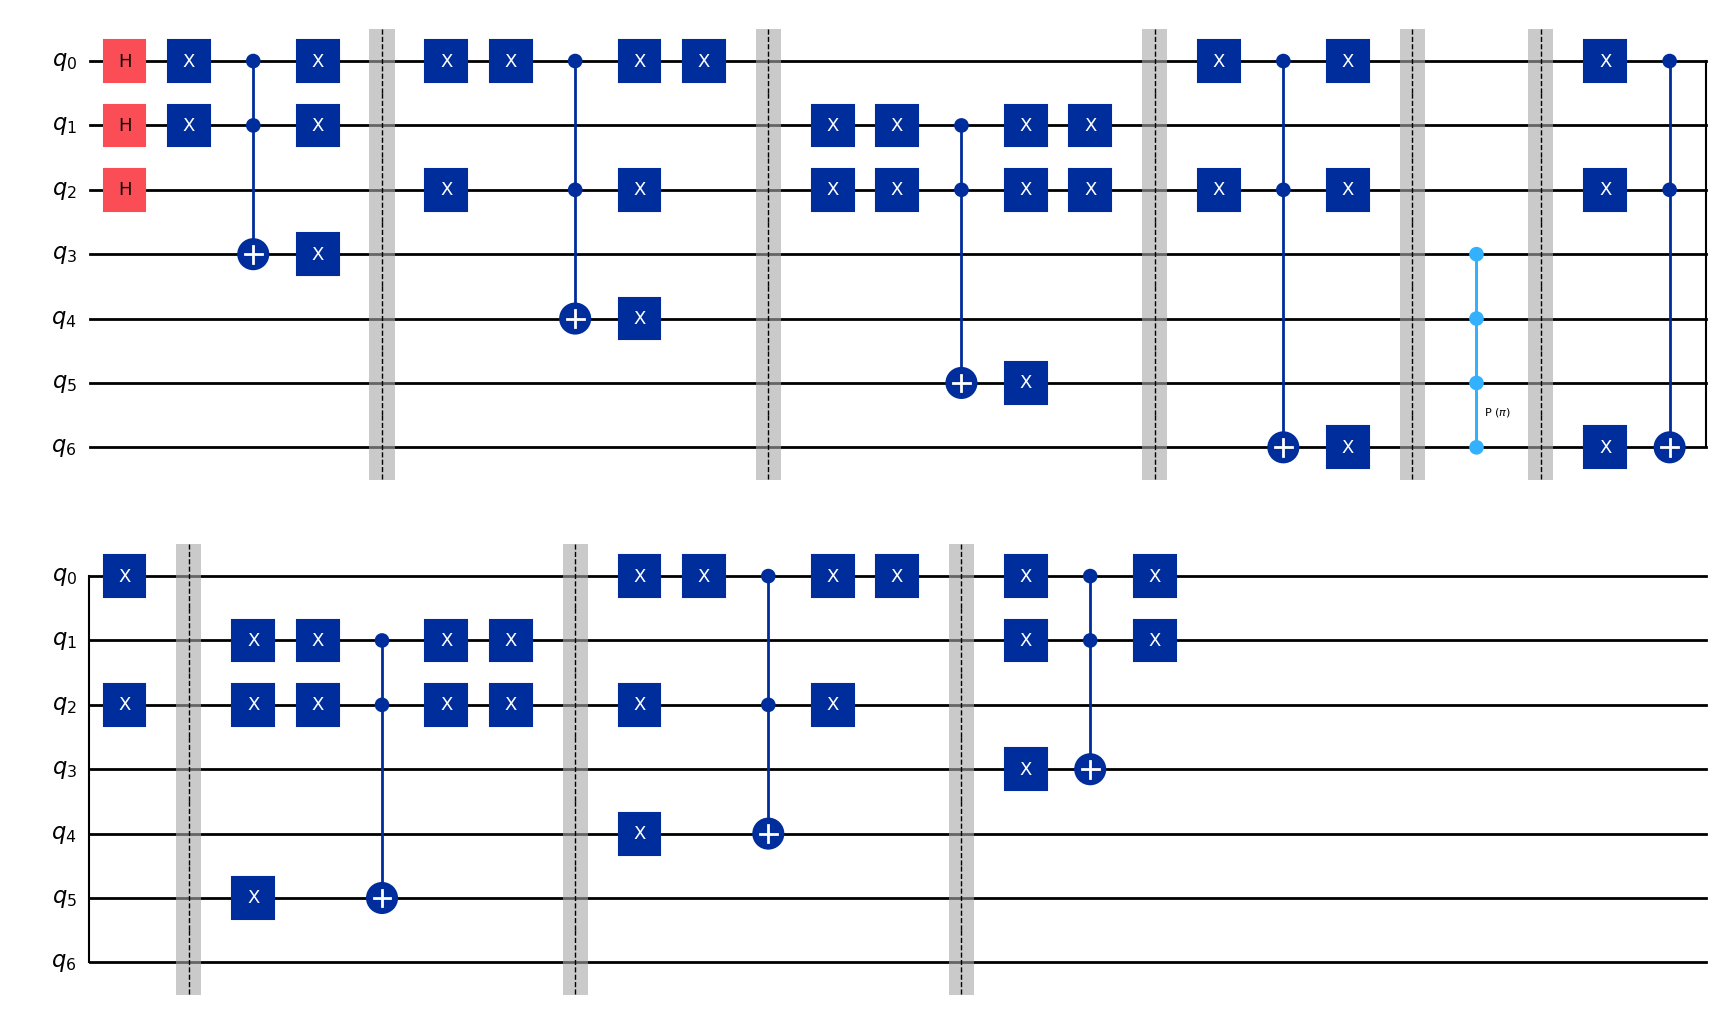

In [72]:
qc.draw(output="mpl")

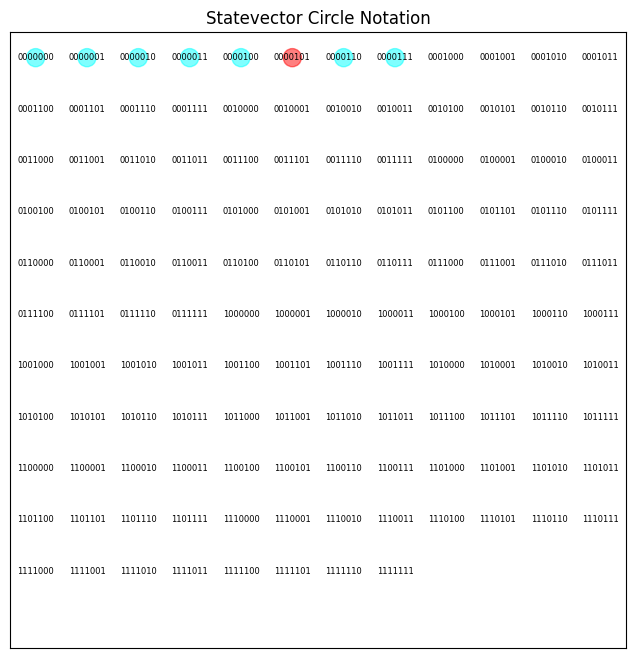

In [73]:
# create statevector
statevector = Statevector(qc)
# plot statevector
plot_statevector_circles(statevector)

In [85]:
def oracle(qc):
    qc.x([0, 1])
    qc.mcx([0, 1], 3)
    qc.x([0, 1, 3])
    qc.barrier()
    qc.x([0])
    qc.x([0, 2])
    qc.mcx([0, 2], 4)
    qc.x([0, 2, 4])
    qc.x([0])
    qc.barrier()
    qc.x([1, 2])
    qc.x([1, 2])
    qc.mcx([1, 2], 5)
    qc.x([1, 2, 5])
    qc.x([1, 2])
    qc.barrier()
    qc.x([0, 2])
    qc.mcx([0, 2], 6)
    qc.x([0, 2, 6])
    
    qc.barrier()
    qc.mcp(np.pi, [3, 4, 5], 6)
    qc.barrier()
    
    qc.x([0, 2, 6])
    qc.mcx([0, 2], 6)
    qc.x([0, 2])
    qc.barrier()
    qc.x([1, 2])
    qc.x([1, 2, 5])
    qc.mcx([1, 2], 5)
    qc.x([1, 2])
    qc.x([1, 2])
    qc.barrier()
    qc.x([0])
    qc.x([0, 2, 4])
    qc.mcx([0, 2], 4)
    qc.x([0, 2])
    qc.x([0])
    qc.barrier()
    qc.x([0, 1, 3])
    qc.mcx([0, 1], 3)
    qc.x([0, 1])

In [86]:
def diffuser(qc, n):
    qc.h(range(n))
    qc.x(range(n))
    qc.mcp(np.pi, list(range(n-1)), n - 1)
    qc.x(range(n))
    qc.h(range(n))

In [87]:
n = 7
qc = QuantumCircuit(n)
qc.h([0, 1, 2])

for i in range(3):
    oracle(qc)
    diffuser(qc, 3)
    
qc.measure_all()
result = Sampler().run([qc], shots=100).result()[0]
co = result.data.meas.get_counts()

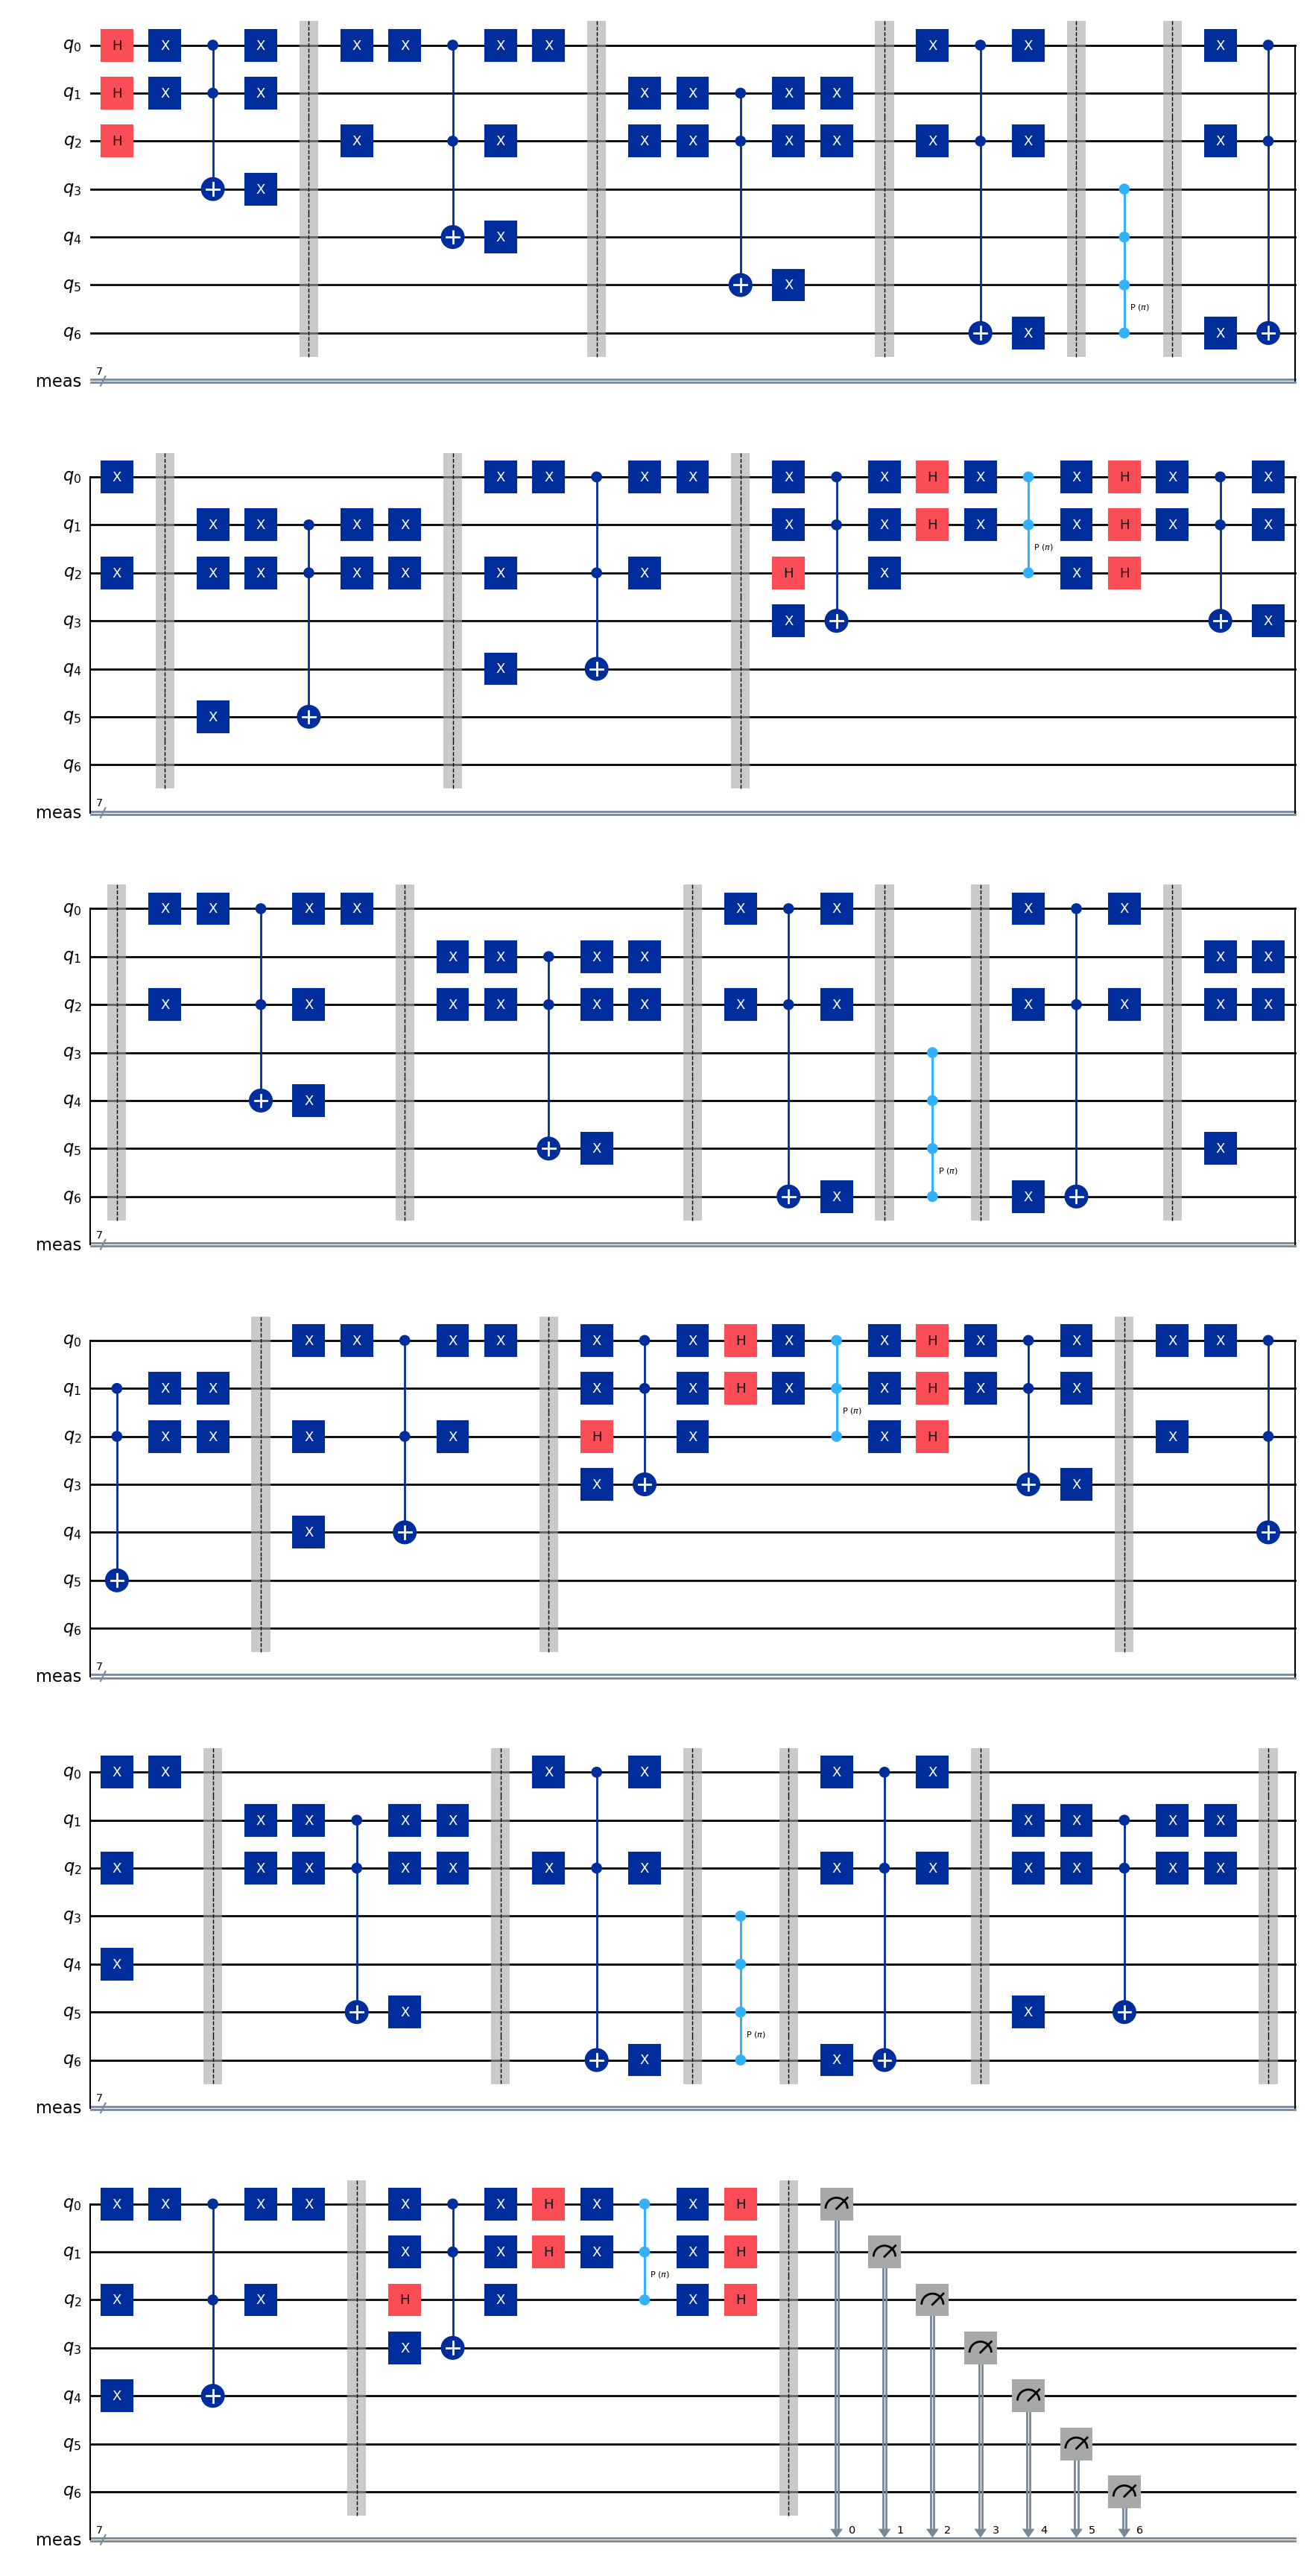

In [89]:
qc.draw(output="mpl")

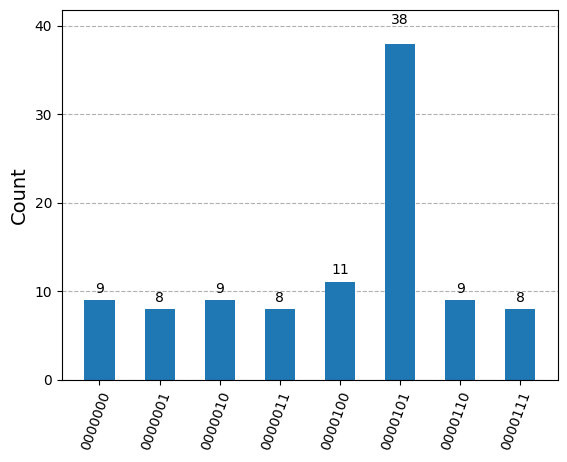

In [88]:
plot_histogram(co)